Credit to Selva Prabhakaran for starter code on VAR
https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

This notebook uses Vector Autoregression to make predictions

We use the following features:
- playerId
- target1
- target2
- target3
- target4
- playerTwitterFollowers

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore")

import gc
from pathlib import Path

# Data Preprocessing

The pickle file contains a merge of dailyDataDate, playerId, target1, target2, target3, target4 and numberOfFollowers. Any rows with missing values have been removed from the dataset. Although this may lead to loss of information, this is not a serious issue as we have a large dataset.

In [2]:
# download dataset
data = pd.read_pickle('./playerFollowersEng.pkl')

In [19]:
data

,dailyDataDate,playerId,target1,target2,target3,target4,numberOfFollowers
0,2018-01-01,519317,0.974327,56.177043,13.693746,64.166667,288755
1,2018-01-01,607625,0.006700,2.675097,0.005168,1.862745,8956
2,2018-01-01,606959,0.024009,2.188716,0.039127,0.539216,8372
3,2018-01-01,502179,0.000000,1.021401,0.000738,0.245098,1306
4,2018-01-01,543939,0.012284,6.566148,0.001476,2.352941,143320
...,...,...,...,...,...,...,...
30976,2021-04-01,605255,0.000000,0.038447,0.000000,0.062189,1974
30977,2021-04-01,475857,0.000000,0.005492,0.000000,0.186567,19875
30978,2021-04-01,624431,0.013502,2.817598,0.000000,0.549337,11010
30979,2021-04-01,670768,0.000441,0.346021,0.000000,0.269486,1449


In [20]:
# check the percentage of missing data in each column
per_missing = data.isna().sum()*100/len(data)
per_missing.sort_values(ascending=False)

numberOfFollowers    0.0
target4              0.0
target3              0.0
target2              0.0
target1              0.0
playerId             0.0
dailyDataDate        0.0
dtype: float64

In [21]:
import datetime 

# check for the period covered by the data (total number of days)
data['dailyDataDate'] = pd.to_datetime(data['dailyDataDate']).dt.normalize()
(data.dailyDataDate.max() - data.dailyDataDate.min()) + datetime.timedelta(days=1)

Timedelta('1187 days 00:00:00')

In [22]:
var_df = data.groupby(['dailyDataDate', 'playerId'])[['target1', 'target2', 'target3', 
                                                      'target4', 'numberOfFollowers']].sum().reset_index()

var_df.head()

,dailyDataDate,playerId,target1,target2,target3,target4,numberOfFollowers
0,2018-01-01,282332,0.221666,12.451362,0.392009,12.990196,461499
1,2018-01-01,405395,0.151872,21.449416,0.112952,22.990196,196335
2,2018-01-01,408234,0.029593,13.375486,4.234585,16.960784,1187972
3,2018-01-01,408252,0.016192,4.231518,0.002215,5.441176,1109433
4,2018-01-01,408314,0.059744,5.350195,0.002215,4.558824,174050


In [ ]:
# plotting data

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(22,20))

sns.lineplot(x=var_df.dailyDataDate, y=var_df.target1, ax=ax[0], color='b')
ax[0].set_title('Target 1 Over Time', fontsize=14)

sns.lineplot(x=var_df.dailyDataDate, y=var_df.target2, ax=ax[1], color='b')
ax[1].set_title('Target 2 Over Time', fontsize=14)

sns.lineplot(x=var_df.dailyDataDate, y=var_df.target3, ax=ax[2], color='b')
ax[2].set_title('Target 3 Over Time', fontsize=14)

sns.lineplot(x=var_df.dailyDataDate, y=var_df.target4, ax=ax[3], color='b')
ax[3].set_title('Target 4 Over Time', fontsize=14)

sns.lineplot(x=var_df.dailyDataDate, y=var_df.numberOfFollowers, ax=ax[4], color='b')
ax[4].set_title('Number of Player Twitter Followers Over Time', fontsize=14)

plt.tight_layout()
plt.show()


<h2>Checking for Causality</h2>

<p>Granger casuality is a concept of causality derived from the notion that causes may not occur after effects and that if one variable is the cause of another, knowing the status on the cause at an earlier point in time can enhance prediction of the effect at a later point in time </p>
Taken from: Vector Autoregressive (VAR) Models and Granger Causality in Time Series Analysis in Nursing Research: Dynamic Changes Among Vital Signs Prior to Cardiorespiratory Instability Events as an Example

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
'''
Check Granger Causality of all possible combinations of the time series.
Rows are the response variable and the columns are predictors.

==== Params ====
data: pandas dataframe
variables: list containing names of the time series variables
maxlag: the maximum number of lags the time series uses 
'''
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, maxlag=20):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df  

In [ ]:
grangers_causation_matrix(var_df, variables = ['target1', 'target2', 'target3', 'target4', 'numberOfFollowers']) 

The test Null Hypothesis is that the coefficients of the corresponding past values are zero; That is X does not cause Y. We shall select all the features for which the p-values are less than our significance level (0.05) wrt to the targetAvg. This implies that the Null Hypothesis can be rejected 

Hence since the p-values in table above are all less than 0.05, each variable Granger causes the predictors. Thus all feature will be included in our model's feature set.

In [24]:
# normalising numberOfFollowers between 0 and 100 (similar to target values)
nvar_df = var_df[['numberOfFollowers']]
nFollowers = (nvar_df - nvar_df.min())/(nvar_df.max() - nvar_df.min()) * 100
var_df['numberOfFollowers'] = nFollowers

,numberOfFollowers
0,17.985351
1,7.651465
2,46.297223
3,43.236426
4,6.782982
...,...
30976,0.040063
30977,0.062744
30978,0.043375
30979,0.057327


# Train and test split

We shall split the training set as all data points before 2021-04-01. All points after this date shall be in the test set.

In [27]:
index=var_df['dailyDataDate']<'2021-04-01'
df_train, df_test = var_df.loc[index], var_df[~index]

In [28]:
df_train

,dailyDataDate,playerId,target1,target2,target3,target4,numberOfFollowers
0,2018-01-01,282332,0.221666,12.451362,0.392009,12.990196,17.985351
1,2018-01-01,405395,0.151872,21.449416,0.112952,22.990196,7.651465
2,2018-01-01,408234,0.029593,13.375486,4.234585,16.960784,46.297223
3,2018-01-01,408252,0.016192,4.231518,0.002215,5.441176,43.236426
4,2018-01-01,408314,0.059744,5.350195,0.002215,4.558824,6.782982
...,...,...,...,...,...,...,...
29860,2021-03-01,680704,0.000859,0.410919,0.001957,0.100781,0.039439
29861,2021-03-01,680777,0.006870,2.406810,0.000000,0.251953,0.061926
29862,2021-03-01,680911,0.000286,7.601996,0.001957,0.100781,0.042713
29863,2021-03-01,681911,0.002290,13.619020,3.237424,2.154195,0.055963


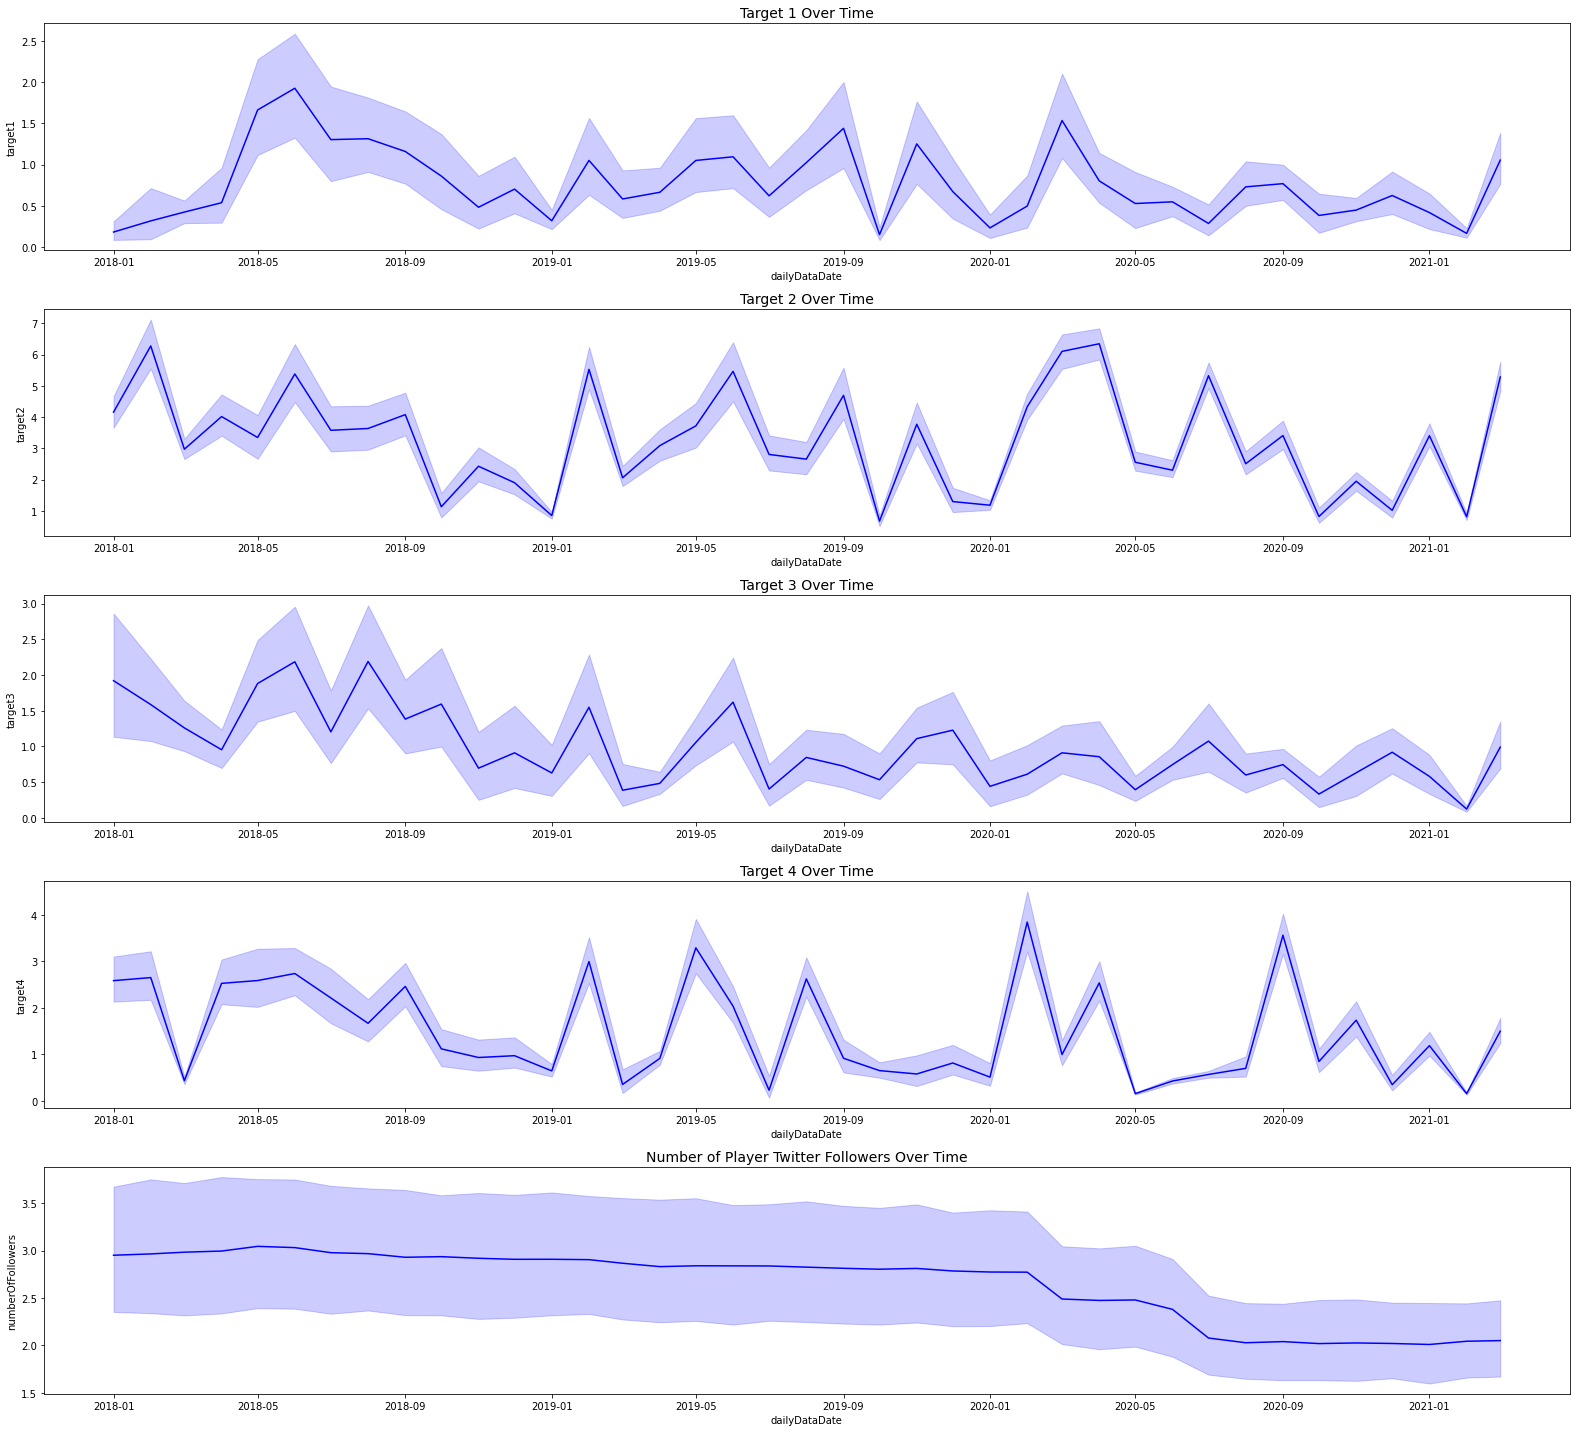

In [29]:
# plot train set data

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(22,20))

sns.lineplot(x=df_train.dailyDataDate, y=df_train.target1, ax=ax[0], color='b')
ax[0].set_title('Target 1 Over Time', fontsize=14)

sns.lineplot(x=df_train.dailyDataDate, y=df_train.target2, ax=ax[1], color='b')
ax[1].set_title('Target 2 Over Time', fontsize=14)

sns.lineplot(x=df_train.dailyDataDate, y=df_train.target3, ax=ax[2], color='b')
ax[2].set_title('Target 3 Over Time', fontsize=14)

sns.lineplot(x=df_train.dailyDataDate, y=df_train.target4, ax=ax[3], color='b')
ax[3].set_title('Target 4 Over Time', fontsize=14)

sns.lineplot(x=df_train.dailyDataDate, y=df_train.numberOfFollowers, ax=ax[4], color='b')
ax[4].set_title('Number of Player Twitter Followers Over Time', fontsize=14)

plt.tight_layout()
plt.show()

<h2>Checking Stationarity</h2>

Unit root test - checking for stationality In statistics, a unit root test tests whether a time series variable is non-stationary and possesses a unit root. The null hypothesis is generally defined as the presence of a unit root and the alternatibe hypothesis is either stationarity, trend stationarity or explosive root depending on the test used.

In [30]:
from statsmodels.tsa.stattools import adfuller
'''
Perform Augmented Dickey-Fuller Test for Stationarity

==== Params ====
series: a feature of the time series
signif: the significance level 
name: name of the feature of the time series
'''
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [31]:
# ADF Test on each column - for training set
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "dailyDataDate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 6.1354
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "playerId" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.3446
 No. Lags Chosen       = 7
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "target1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stat

<h2>Checking for Cointegration</h2>

Cointegration tests analyse non-stationary time series— processes that have variances and means that vary over time. If time series are cointegrated, then they exhibit a long-run relationship, which is appropriate for VAR.

The null hypothesis is that there are no cointegrated equations.

In [32]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

'''
Perform Johansen's Cointegration Test

==== Params ====
df: the dataset
alpha: critical value
'''
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [33]:
cointegration_test(df_train[['target1', 'target2', 'target3', 'target4', 'numberOfFollowers']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
target1 ::  15931.17  > 60.0627   =>   True
target2 ::  11489.1   > 40.1749   =>   True
target3 ::  7395.11   > 24.2761   =>   True
target4 ::  4209.74   > 12.3212   =>   True
numberOfFollowers ::  1371.22   > 4.1296    =>   True


Since the test statistic is greater than the critical values, then we reject the null hypothesis. Hence, our features exhibit a long-run relationship, meaning that our dataset is appropriate for the VAR model.

In [34]:
# since training set is not stationary due to seasonality, take the first difference

ts_diff = np.diff(df_train.target1)
df_train['target1_1d'] = np.append([0], ts_diff)

ts_diff = np.diff(df_train.target2)
df_train['target2_1d'] = np.append([0], ts_diff)

ts_diff = np.diff(df_train.target3)
df_train['target3_1d'] = np.append([0], ts_diff)

ts_diff = np.diff(df_train.target4)
df_train['target4_1d'] = np.append([0], ts_diff)

ts_diff = np.diff(df_train.numberOfFollowers)
df_train['numberOfFollowers_1d'] = np.append([0], ts_diff)

df_train.set_index('dailyDataDate')

,playerId,target1,target2,target3,target4,numberOfFollowers,target1_1d,target2_1d,target3_1d,target4_1d,numberOfFollowers_1d
dailyDataDate,,,,,,,,,,,
2018-01-01,282332,0.221666,12.451362,0.392009,12.990196,17.985351,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-01,405395,0.151872,21.449416,0.112952,22.990196,7.651465,-0.069794,8.998054,-0.279057,10.000000,-10.333886
2018-01-01,408234,0.029593,13.375486,4.234585,16.960784,46.297223,-0.122279,-8.073930,4.121634,-6.029412,38.645758
2018-01-01,408252,0.016192,4.231518,0.002215,5.441176,43.236426,-0.013400,-9.143969,-4.232371,-11.519608,-3.060797
2018-01-01,408314,0.059744,5.350195,0.002215,4.558824,6.782982,0.043552,1.118677,0.000000,-0.882353,-36.453445
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01,680704,0.000859,0.410919,0.001957,0.100781,0.039439,-0.001145,-0.440270,0.001957,-0.050391,0.005612
2021-03-01,680777,0.006870,2.406810,0.000000,0.251953,0.061926,0.006012,1.995891,-0.001957,0.151172,0.022487
2021-03-01,680911,0.000286,7.601996,0.001957,0.100781,0.042713,-0.006584,5.195186,0.001957,-0.151172,-0.019213


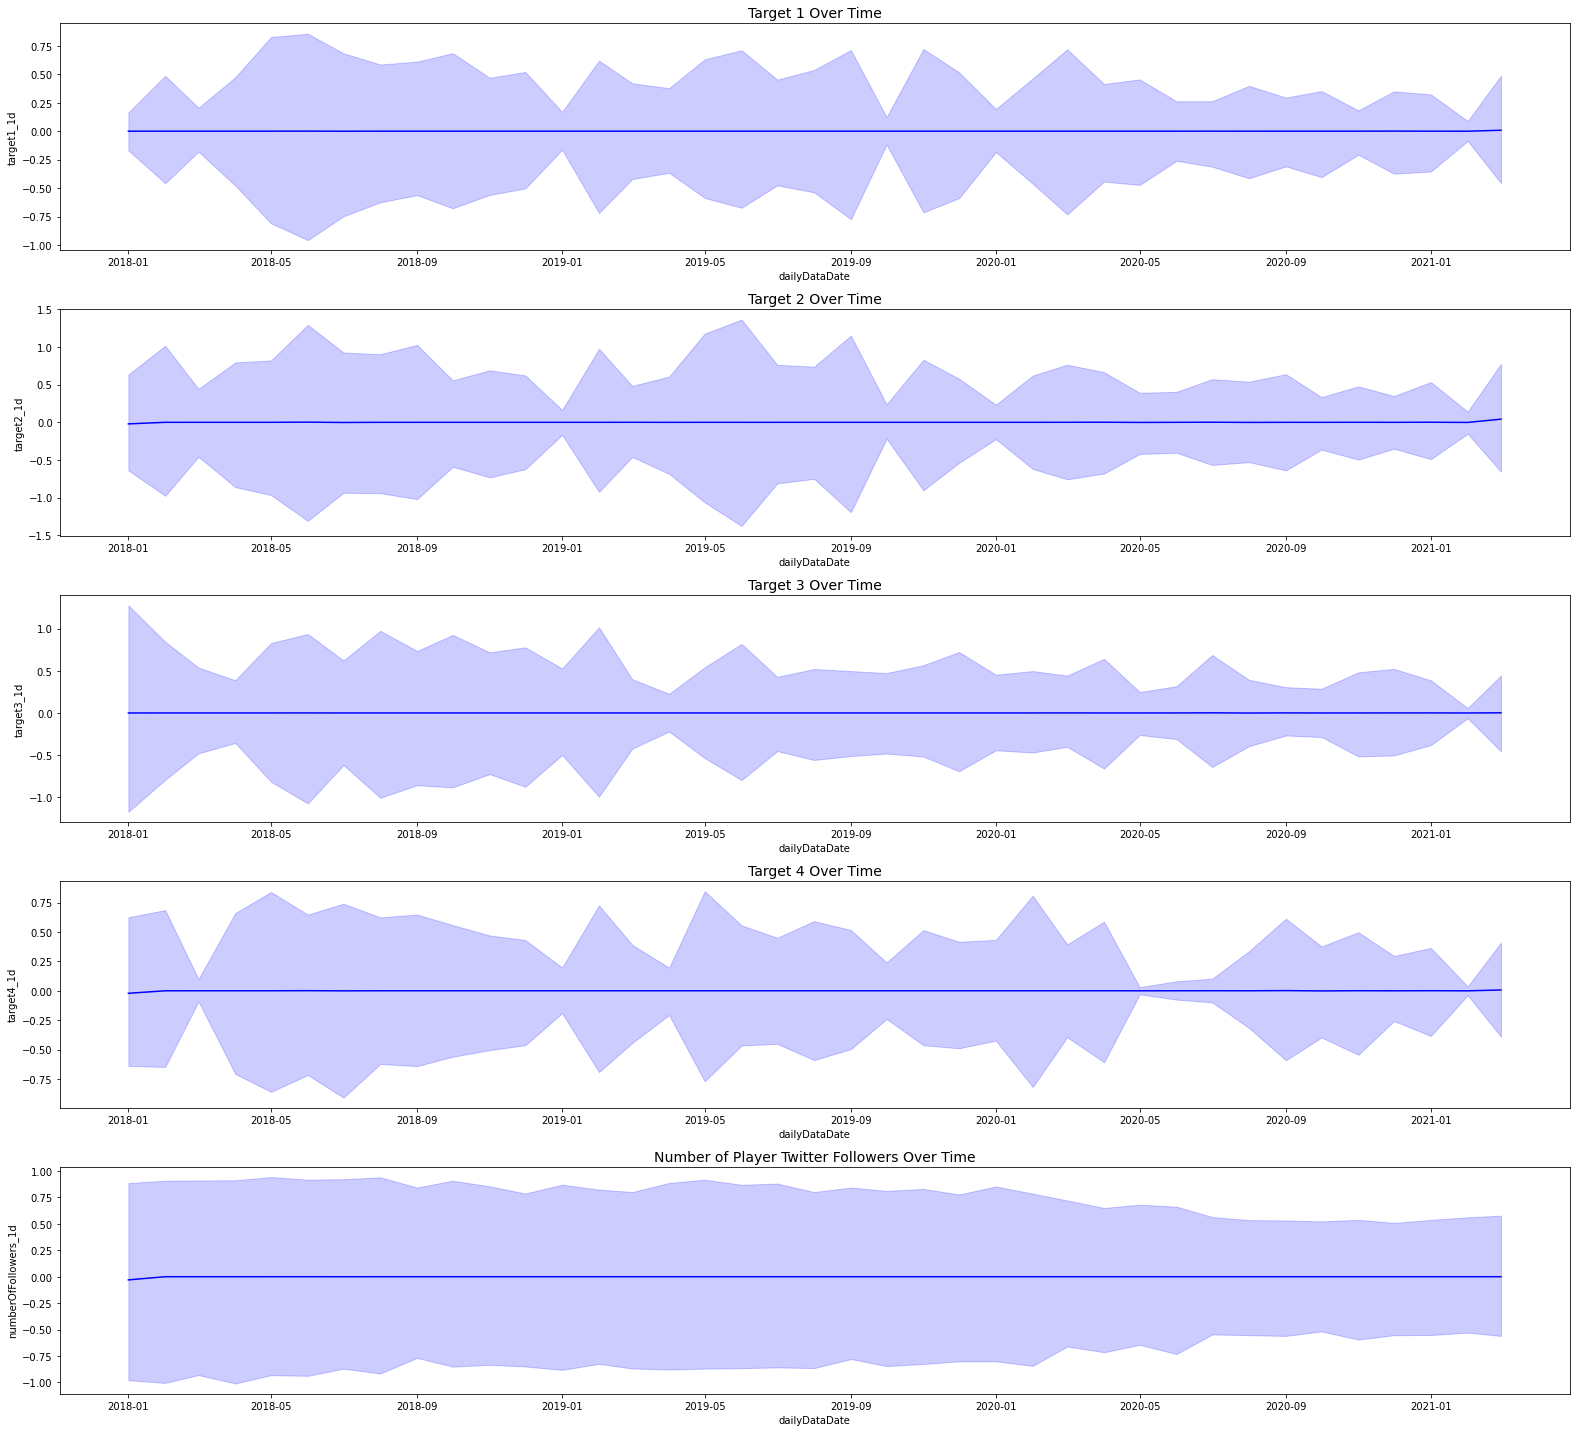

In [35]:
# plot training set after first difference

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(22,20))

sns.lineplot(x=df_train.dailyDataDate, y=df_train.target1_1d, ax=ax[0], color='b')
ax[0].set_title('Target 1 Over Time', fontsize=14)

sns.lineplot(x=df_train.dailyDataDate, y=df_train.target2_1d, ax=ax[1], color='b')
ax[1].set_title('Target 2 Over Time', fontsize=14)

sns.lineplot(x=df_train.dailyDataDate, y=df_train.target3_1d, ax=ax[2], color='b')
ax[2].set_title('Target 3 Over Time', fontsize=14)

sns.lineplot(x=df_train.dailyDataDate, y=df_train.target4_1d, ax=ax[3], color='b')
ax[3].set_title('Target 4 Over Time', fontsize=14)

sns.lineplot(x=df_train.dailyDataDate, y=df_train.numberOfFollowers_1d, ax=ax[4], color='b')
ax[4].set_title('Number of Player Twitter Followers Over Time', fontsize=14)

plt.tight_layout()
plt.show()


In [36]:
df_train_d = df_train.copy()
df_train_d = df_train_d.drop(['target1', 'target2', 'target3', 'target4', 'numberOfFollowers'], axis=1)

# ADF Test on each column - training set
for name, column in df_train_d.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "dailyDataDate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 6.1354
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "playerId" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.3446
 No. Lags Chosen       = 7
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "target1_1d" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-S

In [37]:
# ADF Test on each column - test set
for name, column in df_test.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "dailyDataDate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = nan
 No. Lags Chosen       = 0
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "playerId" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.6313
 No. Lags Chosen       = 3
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "target1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stati

# Modelling

<h2>K Fold Cross Validation</h2>

Performed various KFold CVs to determine the best lag to fit our model. Commented out as we have already arrived at our final model (without using cross validation)

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# N_SPLITS = 3

# X = df_train_d.dailyDataDate
# y = df_train_d[['target1_1d', 'target2_1d', 'target3_1d', 'target4_1d', 'numberOfFollowers_1d']]

# folds = TimeSeriesSplit(n_splits=N_SPLITS)


In [ ]:
# from statsmodels.tsa.api import VAR
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# warnings.filterwarnings("ignore")

# '''
# Performs cross validation and returns the MCMAE score

# ==== Params ====
# lag_order: the number of lags the model is fitted on
# folds: the number of folds
# '''
# def cross_validation_score(lag_order, folds):
    
#     score_mae = []
#     score_mse = []
    
#     for train_index, val_index in folds.split(X):
#         mae = []
#         mse = []

#         # prepare training and validation data for this fold
#         X_train, X_valid = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_valid = y.iloc[train_index], y.iloc[val_index]
        
#         data = pd.concat([X_train, y_train], axis=1)
#         data = data.set_index('dailyDataDate')

#         # fit model 
#         model = VAR(data)
#         fitted = model.fit(lag_order)
        
#         # prediction 
#         y_val_pred = fitted.forecast(fitted.y, steps=X_valid.shape[0])
#         y_val_pred = pd.DataFrame(y_val_pred)
            
        
#         # calculate metrics
#         mae.append(mean_absolute_error(y_valid.target1_1d, y_val_pred.iloc[:, 0]))
#         mae.append(mean_absolute_error(y_valid.target2_1d, y_val_pred.iloc[:, 1]))
#         mae.append(mean_absolute_error(y_valid.target3_1d, y_val_pred.iloc[:, 2]))
#         mae.append(mean_absolute_error(y_valid.target4_1d, y_val_pred.iloc[:, 3]))
        
#         # get mean mae of targets
#         score_mae.append(np.mean(mae))
        
#     return np.mean(score_mae)

In [ ]:
# '''
# Returns the best lag and corresponding scores based on the lowest loss.

# ==== Params ====
# max_lag
# folds: number of folds
# '''
# def get_best_lag(max_lag, folds):
#     lag_score = {}
#     for lag in range(1, max_lag + 1):
#         lag_score[lag] = cross_validation_score(lag, folds)
    
#     # find min score
#     best_lag = min(lag_score, key=lag_score.get)
    
#     return best_lag, lag_score

# max_lag = 50
# get_best_lag(max_lag, folds)

<h2>Training</h2>

In [38]:
from statsmodels.tsa.api import VAR

df_train_d = df_train_d.set_index('dailyDataDate')
model = VAR(df_train_d[['target1_1d', 'target2_1d', 'target3_1d', 'target4_1d', 'numberOfFollowers_1d']])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [39]:
model.select_order(100).summary()

,AIC,BIC,FPE,HQIC
0,19.83,19.84,4.111e+08,19.83
1,18.43,18.44,1.014e+08,18.44
2,17.89,17.90,5.867e+07,17.89
3,17.52,17.54,4.051e+07,17.52
4,17.30,17.33,3.261e+07,17.31
5,17.17,17.20,2.857e+07,17.18
6,17.05,17.09,2.540e+07,17.06
7,16.99,17.04,2.380e+07,17.00
8,16.93,16.99,2.263e+07,16.95
9,16.89,16.95,2.162e+07,16.91


In [40]:
# choosing a lag of 77 based on AIC
fitted = model.fit(77)
fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Jul, 2021
Time:                     17:01:54
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    17.0798
Nobs:                     29788.0    HQIC:                   16.7145
Log likelihood:          -455781.    FPE:                1.52774e+07
AIC:                      16.5419    Det(Omega_mle):     1.43249e+07
--------------------------------------------------------------------
Results for equation target1_1d
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.000639         0.027740            0.023           0.982
L1.target1_1d                   -0.992962         0.007141         -139.048           0.000
L1.target2_

<h2>Check Durbin Watson</h2>

Output of Durbin-Watson test is denoted as d. This output always lies between 0 and 4.
- d = 2: no autocorrelation
- d < 2: evidence of positive serial correlation. Generally, if d < 1.0, there may be an issue. Small values of d indicate successive error terms are positively correlated (cannot use VAR)
- d > 2: successive error terms are negatively correlated. This can imply underestimation of the level of statistical significance

In [41]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(fitted.resid)

for col, val in zip(df_train_d[['target1_1d', 'target2_1d', 'target3_1d', 'target4_1d', 'numberOfFollowers_1d']], out):
    print(col, ':', round(val, 2))

target1_1d : 2.0
target2_1d : 2.0
target3_1d : 2.0
target4_1d : 2.0
numberOfFollowers_1d : 2.0


We have no autocorrelation

# Forecasting

In [42]:
df_train_fc = df_train_d[['target1_1d', 'target2_1d', 'target3_1d', 'target4_1d', 'numberOfFollowers_1d']]

In [43]:
lag_order = fitted.k_ar

df_train_d.drop(['playerId'], axis=1, inplace=True)
ntest = df_test.shape[0]

predict = fitted.forecast(df_train_d.values[-lag_order:], steps=ntest)
df_forecast = pd.DataFrame(predict, index=df_train_fc.index[-ntest:], columns=df_train_fc.columns)
df_forecast

,target1_1d,target2_1d,target3_1d,target4_1d,numberOfFollowers_1d
dailyDataDate,,,,,
2021-02-01,-7.412926,-37.752264,0.212061,-6.306044,0.218751
2021-02-01,0.391468,1.972633,-0.088067,0.406777,-0.681007
2021-02-01,-0.252267,-1.967232,-0.341751,0.088123,0.839131
2021-02-01,-0.827912,0.450511,-0.025489,0.450308,-0.385299
2021-02-01,1.143498,0.625549,0.075141,-0.645969,0.528595
...,...,...,...,...,...
2021-03-01,0.000026,-0.000045,-0.000209,-0.000148,-0.000212
2021-03-01,0.000026,-0.000045,-0.000209,-0.000148,-0.000212
2021-03-01,0.000026,-0.000045,-0.000209,-0.000148,-0.000212


In [44]:
'''
Revert back the differencing to get the forecasr to original scale

==== Params ====
df_train: training dataset
df_forecast: predictions dataset
'''
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    df_t = df_train.drop(['playerId', 'target1_1d', 'target2_1d', 'target3_1d', 'target4_1d', 'numberOfFollowers_1d'], axis=1)
    columns = df_t.columns
    for col in columns[1:]:        
        # Roll back 1st Diff
        df_fc[str(col)+'_f'] = df_t[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [45]:
df_results = invert_transformation(df_train, df_forecast)
df_results = df_results.loc[:, ['target1_f', 'target2_f', 'target3_f', 'target4_f', 'numberOfFollowers_f']]
df_results

,target1_f,target2_f,target3_f,target4_f,numberOfFollowers_f
dailyDataDate,,,,,
2021-02-01,1.429168,6.832415,2.267258,0.811618,0.286796
2021-02-01,1.820637,8.805048,2.179191,1.218394,-0.394211
2021-02-01,1.568370,6.837816,1.837440,1.306517,0.444920
2021-02-01,0.740458,7.288327,1.811951,1.756825,0.059621
2021-02-01,1.883956,7.913876,1.887093,1.110856,0.588217
...,...,...,...,...,...
2021-03-01,0.930604,6.623740,0.594617,0.697062,-0.229192
2021-03-01,0.930631,6.623695,0.594408,0.696914,-0.229404
2021-03-01,0.930657,6.623650,0.594199,0.696766,-0.229617


In [46]:
'''
Print summary of forecast accuracy
'''
def forecast_accuracy(forecast, actual):
    mae_li = []
    mse_li = []
    for i in range(len(forecast)): 
        mae = np.abs(forecast[i] - actual[i])
        mae_li.append(mae)
        mse = (forecast[i] - actual[i])**2
        mse_li.append(mse)
    return(np.mean(mae_li), np.mean(mse_li))

In [47]:
df_test = df_test.set_index('dailyDataDate')

In [48]:
print('Forecast Accuracy of: Target 1')
accuracy_prod = forecast_accuracy(df_results.iloc[:, 0], df_test['target1'])
print('mae: ', accuracy_prod[0])
print('mse: ', accuracy_prod[1])
score1 = accuracy_prod[0]
    
print('Forecast Accuracy of: Target 2')
accuracy_prod = forecast_accuracy(df_results.iloc[:, 1], df_test['target2'])
print('mae: ', accuracy_prod[0])
print('mse: ', accuracy_prod[1])
score2 = accuracy_prod[0]
    
print('Forecast Accuracy of: Target 3')
accuracy_prod = forecast_accuracy(df_results.iloc[:, 2], df_test['target3'])
print('mae: ', accuracy_prod[0])
print('mse: ', accuracy_prod[1])
score3 = accuracy_prod[0]
    
print('Forecast Accuracy of: Target 4')
accuracy_prod = forecast_accuracy(df_results.iloc[:, 3], df_test['target4'])
print('mae: ', accuracy_prod[0])
print('mse: ', accuracy_prod[1])
score4 = accuracy_prod[0]

print('score: ', (score1 + score2 + score3 + score4)/4)

Forecast Accuracy of: Target 1
mae:  1.461469808915275
mse:  21.12051559676596
Forecast Accuracy of: Target 2
mae:  6.155860832555195
mse:  69.48183029262108
Forecast Accuracy of: Target 3
mae:  1.8644215073337407
mse:  60.14083031662892
Forecast Accuracy of: Target 4
mae:  2.2729689118121925
mse:  44.572226966207566
score:  2.938680265154101
